In [1]:
#!/usr/bin/env python3

%reload_ext autoreload
%autoreload 2

# System
import os
import sys
from tqdm.notebook import tqdm

# Maths
import numpy as np

# PCovR utilities
from regression import LR, KRR, SparseKRR, PCovR, KPCovR, SparseKPCovR
from decomposition import PCA, KPCA, SparseKPCA
from kernels import build_kernel, center_kernel
from tools import FPS, simple_split, CUR

# ASE
from ase.io import read, write

# SOAP
from rascal.representations import SphericalInvariants as SOAP

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Make the plots look nicer
plot_parameters = {
    'lines.linewidth': 1.0,
    'lines.markersize': 2,
    'patch.linewidth': 1.0,
    'hatch.linewidth': 1.0,
    'axes.linewidth': 1.0,
    'xtick.top': True,
    'xtick.bottom': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'xtick.major.size': 4.0,
    'xtick.minor.size': 2.0,
    'xtick.major.pad': 5.0,
    'xtick.minor.pad': 5.0,
    'ytick.left': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
    'ytick.major.size': 4.0,
    'ytick.minor.size': 2.0,
    'ytick.major.pad': 5.0,
    'ytick.minor.pad': 5.0   
}

for pp in plot_parameters.keys():
    mpl.rcParams[pp] = plot_parameters[pp]

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# Read xyz files
s = read('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/datasets/CSD-1000R.xyz', index=':5')

# Extract chemical shifts
cs = []
for ss in s:
    ss.wrap()
    cs.append(ss.arrays['CS_local'])

In [3]:
# Compute SOAPs (from librascal tutorial)
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

In [4]:
soap_rep = soap.transform(s)

In [5]:
X = soap_rep.get_features(soap)
Y = np.concatenate(cs)

In [6]:
# Split SOAPs into structures
n_atoms = [ss.get_number_of_atoms() for ss in s]
structure_idxs = np.cumsum(n_atoms)

X_split = np.split(X, structure_idxs[0:-1]) # Last one is empty by construction of np.split
Y_split = np.split(Y, structure_idxs[0:-1])

In [7]:
# Train-Test split by structures
f_train = 0.80
n_total = len(X_split)
n_train = int(np.floor(f_train*n_total))

idxs = np.arange(0, n_total)
np.random.shuffle(idxs)
idxs_train = idxs[0:n_train]
idxs_test = idxs[n_train:]

X_train = [X_split[i] for i in idxs_train]
Y_train = [Y_split[i] for i in idxs_train]
structure_idxs_train = np.cumsum([n_atoms[i] for i in idxs_train])

X_test = [X_split[i] for i in idxs_test]
Y_test = [Y_split[i] for i in idxs_test]
structure_idxs_test = np.cumsum([n_atoms[i] for i in idxs_test])

print(n_atoms)
print(idxs_train, idxs_test)
print(structure_idxs_train)
print(structure_idxs_test)
print([x.shape for x in X_train])
print([x.shape for x in X_test])

X_train = np.concatenate(X_train, axis=0)
Y_train = np.concatenate(Y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0)

[180, 84, 176, 176, 104]
[4 0 1 2] [3]
[104 284 368 544]
[176]
[(104, 2520), (180, 2520), (84, 2520), (176, 2520)]
[(176, 2520)]


In [8]:
# Center the data
X_mean = np.mean(X_train, axis=0)
Y_mean = np.mean(Y_train)

X_train -= X_mean
X_test -= X_mean
Y_train -= Y_mean
Y_test -= Y_mean

# FPS

In [9]:
# Select FPS components from train set
n_FPS = 20
idxs, d = FPS(X_train.T, n_FPS)

X_train = X_train[:, idxs]
X_test = X_test[:, idxs]

In [10]:
# Select FPS environments from train set
n_env_FPS = 100
env_idxs, env_d = FPS(X_train, n_env_FPS)

In [24]:
X_train_split = np.split(X_train, structure_idxs_train)[0:-1]
Y_train_split = np.split(Y_train, structure_idxs_train)[0:-1]

X_test_split = np.split(X_test, structure_idxs_test)[0:-1]
Y_test_split = np.split(Y_test, structure_idxs_test)[0:-1]

In [72]:
K_train = build_kernel(X_train_split, X_train_split, kernel='gaussian')
K_test = build_kernel(X_train_split, X_test_split, kernel='gaussian')

In [100]:
K_train_nystrom = build_kernel(X_train_split, X_train_split, XR=X_train[env_idxs, :], kernel='gaussian')
K_test_nystrom = build_kernel(X_train_split, X_test_split, XR=X_train[env_idxs, :], kernel='gaussian')
#K_train_nystrom = build_kernel(X_train_split, X_train_split, XR=X_train_split[0:3], kernel='gaussian')
#K_test_nystrom = build_kernel(X_train_split, X_test_split, XR=X_train_split[0:3], kernel='gaussian')

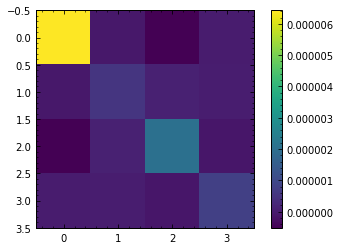

In [101]:
plt.imshow(K_train-K_train_nystrom)
plt.colorbar()
plt.show()

In [102]:
print(np.linalg.norm(K_train - K_train_nystrom))

6.861871922901639e-06


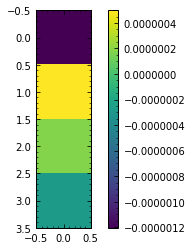

In [103]:
plt.imshow(K_test-K_test_nystrom)
plt.colorbar()
plt.show()

In [104]:
print(np.linalg.norm(K_test-K_test_nystrom))

1.345065249218593e-06
